### 1.Read Input

In [1]:
import textacy

training_records = textacy.io.read_json("datasets/7_training_data.json", lines=True)

### 2. List of Text and Labels

In [2]:
X_train = []
y_train = []

for training_record in training_records:
    
    X_train.append(training_record["text"])
    y_train.append(training_record["class"])

# print(X_train)
# print(y_train)


#### 2.1 Tokening data with spaCy

In [3]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

punctuations = string.punctuation

nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

parser = English()

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    return mytokens

### 3. transforms(): Extract Noun Phrases from Text

Custom transformer function

In [4]:
from sklearn.base import TransformerMixin

class transforms(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        #for text in X:
            # print("TEXT________________________________________")
            # print(text)
        return [transform_text(text) for text in X]
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return {}

def transform_text(text):
    doc = textacy.make_spacy_doc((str(text), {"class": ""}))
    nps = textacy.extract.noun_chunks(doc,
                                      drop_determiners = True,
                                      min_freq = 1)
    doc_nps = [str(np).replace(' ','_') for np in nps]
    nps = ' '.join(doc_nps) # because countvectorizer needs a string
    return (nps)

### 4.Vectorizer (Bag of Words / TfIdf)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

### 5. Classifier (Logistic Regression)

In [6]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='newton-cg',multiclass='multinomial')

### 6.Pipeline

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

transforms()

pipe = Pipeline([("transformer", transforms()),
                ('vectorizer', bow_vector),
                ('classifier', classifier)])

pipe.fit(X_train,y_train)

/home/crosas/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('transformer', <__main__.transforms object at 0x7f893b9ad860>), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
      ...ty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False))])

Read Test data

### 7. Test fitting 

In [ ]:
from sklearn import metrics

predicted = pipe.predict(X_test)

print("Logistic Regression Accuracy: ", metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision: ", metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall: ", metrics.recall_score(y_test, predicted))

In [10]:
%matplotlib inline
import pandas as pd
import numpy as np

import os

df_train_txt = pd.read_csv('./datasets/input/training_text', 
                           sep='\|\|', 
                           header=None, 
                           skiprows=1, 
                           names=["ID","Text"], 
                           engine='python')
df_train_txt.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [11]:
df_train_var = pd.read_csv('./datasets/input/training_variants')
df_train_var.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [12]:
df_test_txt = pd.read_csv('./datasets/input/test_text', 
                          sep='\|\|', 
                          header=None, 
                          skiprows=1, 
                          names=["ID","Text"], 
                          engine='python')
df_test_txt.head()

,ID,Text
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [13]:
df_test_var = pd.read_csv('./datasets/input/test_variants')
df_test_var.head()

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


In [14]:
df_train = pd.merge(df_train_var, df_train_txt, how='left', on='ID')
df_train.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [15]:
df_test = pd.merge(df_test_var, df_test_txt, how='left', on='ID')
df_test.head()

,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


In [16]:
df_train.describe(include='all')

,ID,Gene,Variation,Class,Text
count,3321.000000,3321,3321,3321.000000,3316
unique,NaN,264,2996,NaN,1920
top,NaN,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


In [17]:
df_test.describe(include='all')

,ID,Gene,Variation,Text
count,5668.000000,5668,5668,5667
unique,NaN,1397,5628,5610
top,NaN,F8,Truncating Mutations,Mutations in BRCA1 and BRCA2 account for the m...
freq,NaN,134,18,6
mean,2833.500000,NaN,NaN,NaN
std,1636.354994,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,1416.750000,NaN,NaN,NaN
50%,2833.500000,NaN,NaN,NaN
75%,4250.250000,NaN,NaN,NaN


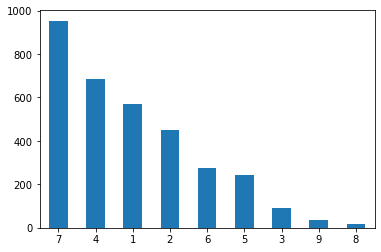

In [18]:
df_train['Class'].value_counts().plot(kind="bar", rot=0)

In [19]:
# This cell reduces the training data for Kaggle limits. Remove this cell for real results.
from sklearn.model_selection import train_test_split

df_train, _ = train_test_split(df_train, test_size=0.7, random_state=8, stratify=df_train['Class'])
df_train.shape

(996, 5)

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
import scikitplot as skplt

def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8, n_splits=5), 
                              n_jobs=-1, method='predict_proba',
                              verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.metrics.plot_confusion_matrix(y, preds)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Log loss: 0.32944872366748057
Accuracy: 0.96


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


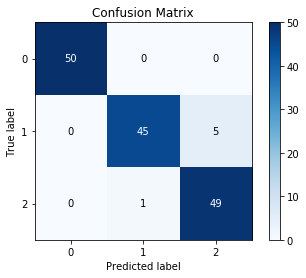

In [21]:

# Quick test of evaluate_features
from sklearn.datasets import load_iris
evaluate_features(*load_iris(True))

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('punkt')

count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    

[nltk_data] Downloading package punkt to /home/crosas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
bag_of_words = count_vectorizer.fit_transform(df_train['Text'].values.astype('U'))

In [24]:
len(count_vectorizer.get_feature_names())

157726

In [25]:
print(count_vectorizer.get_feature_names()[1:15])

['\x013-galactosidase', '\x0150', '\x04g', '!', '#', '$', '%', '&', "'", "''", "''not", "'*", "'-", "'-thiotriphos-"]


In [26]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_bag_of_words = svd.fit_transform(bag_of_words)
print(truncated_bag_of_words)

[[ 4.16384628e+02 -3.67636436e+01  1.77795246e+01 ...  1.16535205e+00
   4.00881468e+00 -4.39113013e-01]
 [ 3.91409653e+02  8.09193663e+00  4.85959737e+01 ...  1.80762278e+01
  -1.97934570e+01  4.81203460e+00]
 [ 4.47336935e+02 -2.23431244e+01 -5.40614817e+01 ... -2.03548693e+01
   2.09906219e+01 -6.26855626e+00]
 ...
 [ 4.64653527e+02 -4.20964478e+00  1.05610262e+01 ...  4.12358148e+01
  -2.01623082e+01  1.87251259e+01]
 [ 1.08012500e+03 -4.06021412e+01 -7.65854900e+01 ...  5.91430437e+00
  -2.85406418e+01  6.58231774e+01]
 [ 3.74935990e+02 -9.03639698e+01  8.26778515e+01 ... -1.58455177e+01
   1.51456841e+01 -2.77895394e+01]]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Log loss: 1.577866634858056
Accuracy: 0.4939759036144578


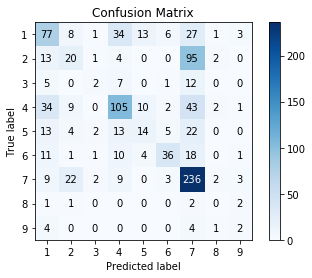

In [27]:
evaluate_features(truncated_bag_of_words, df_train['Class'].values.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Log loss: 1.4374979902374345
Accuracy: 0.5020080321285141


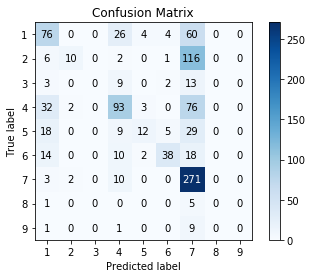

In [28]:
from sklearn.ensemble import RandomForestClassifier

evaluate_features(truncated_bag_of_words, df_train['Class'].values.ravel(), 
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

In [29]:
count_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    

tfidf = count_vectorizer.fit_transform(df_train['Text'].values.astype('U'))

len(count_vectorizer.get_feature_names())

157726

In [30]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_tfidf = svd.fit_transform(tfidf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Log loss: 1.489007642949351
Accuracy: 0.46987951807228917


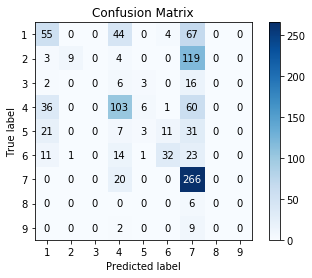

In [31]:
evaluate_features(truncated_tfidf, df_train['Class'].values.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


Log loss: 1.3566675604202754
Accuracy: 0.5030120481927711


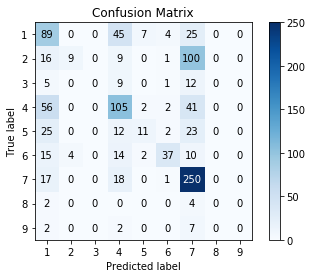

In [32]:
evaluate_features(truncated_tfidf, df_train['Class'].values.ravel(), 
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished


Log loss: 1.1887984370103297
Accuracy: 0.5592369477911646


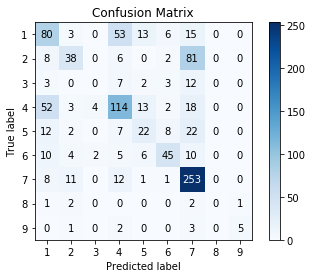

In [33]:
from sklearn.svm import SVC
evaluate_features(tfidf, df_train['Class'].values.ravel(), 
                  SVC(kernel='linear', probability=True))

In [34]:
import gensim

class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

In [35]:
w2vec = get_word2vec(
    MySentences(
        df_train['Text'].values, 
        #df_test['Text'].values  Commented for Kaggle limits
    ),
    'w2vmodel'
)

Found w2vmodel


/home/crosas/local/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [36]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [37]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)
mean_embedded = mean_embedding_vectorizer.fit_transform(df_train['Text'])

/home/crosas/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Log loss: 1.3084490789016354
Accuracy: 0.535140562248996


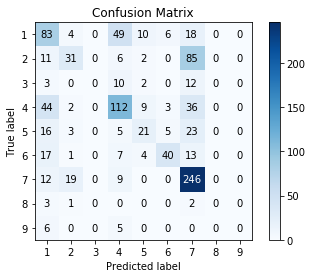

In [38]:
evaluate_features(mean_embedded, df_train['Class'].values.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.4s finished


Log loss: 1.1865912682957027
Accuracy: 0.572289156626506


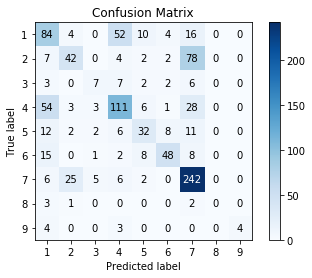

In [39]:
evaluate_features(mean_embedded, df_train['Class'].values.ravel(),
                  RandomForestClassifier(n_estimators=1000, max_depth=15, verbose=1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s finished


Log loss: 1.2496863773623743
Accuracy: 0.5662650602409639


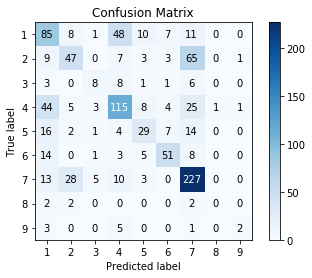

In [40]:
from xgboost import XGBClassifier

evaluate_features(mean_embedded, 
                  df_train['Class'].values.ravel(),
                  XGBClassifier(max_depth=4,
                                objective='multi:softprob',
                                learning_rate=0.03333,
                                )
                 )

***Sentence Tokenization***

In [41]:
nlp = English()

sbd = nlp.create_pipe('sentencizer')

nlp.add_pipe(sbd)

text = """When learning data science, you shouldn't get discouraged!
Challenges and setbacks aren't failures, they're just part of the journey. You've got this!"""

doc = nlp(text)

sents_list = []
for sent in doc.sents:
    sents_list.append(sent.text)
print(sents_list)

["When learning data science, you shouldn't get discouraged!", "\nChallenges and setbacks aren't failures, they're just part of the journey.", "You've got this!"]


***Cleaning Text Data: Removing Stopwords***

In [42]:
import spacy
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

print('Number of stop words: %d' % len(spacy_stopwords))

print('First ten stop words: %s' % list(spacy_stopwords)[:20])

Number of stop words: 326
First ten stop words: ['there', 'seeming', 'has', 'until', 'therein', 'my', 'else', 'always', '’ve', 'it', 'whenever', 'nevertheless', 'nine', 'a', 'at', 'forty', 'that', 'hers', 'twenty', 'just']


In [43]:
from spacy.lang.en.stop_words import STOP_WORDS

filtered_sent = []

doc = nlp(text)

for word in doc:
    if word.is_stop == False:
        filtered_sent.append(word)
print("Filtered Sentence: ", filtered_sent)

Filtered Sentence:  [learning, data, science, ,, discouraged, !, 
, Challenges, setbacks, failures, ,, journey, ., got, !]


***Lexicon Normalization***
- Lemmatization (stemming): reduces words into its roots

In [44]:
lem = nlp("run runs running runner")

for word in lem:
    print(word.text, word.lemma_)

run run
runs run
running run
runner runner


***Part of Speech (POS) Tagging***

In [45]:
# model: contains dictionary and grammatical information
import en_core_web_sm 
# if it fails from anaconda, you can installed directly:
# python -m spacy download en_core_web_sm

nlp = en_core_web_sm.load()

docs = nlp(u"All is well that ends well.")

for word in docs:
    print(word.text, word.pos_)

All DET
is VERB
well ADV
that DET
ends VERB
well ADV
. PUNCT


**Entity Detection**
A.K.A Entity recognition

In [46]:
from spacy import displacy

nytimes = nlp(u"""New York City on Tuesday declared a public health
emergency and ordered mandatory measles vaccinations amid an 
outbreak, becoming the latest national flash point over refusals to
inoculate against dangerous diseases.

At least 285 people have contracted measles in the city since 
September, mostly in Brooklyn’s Williamsburg neighborhood. The
order covers four Zip codes there, Mayor Bill de Blasio (D) said
Tuesday.

The mandate orders all unvaccinated people in the area, including a
concentration of Orthodox Jews, to receive inoculations, including
for children as young as 6 months old. Anyone who resists could be 
fined up to $1,000.""")

entities = [(i, i.label_, i.label) for i in nytimes.ents]
entities

displacy.render(nytimes, style = "ent", jupyter = True)

***Dependency Parsing***
Meaning of a sentence by analyzing how is constructed

In [47]:
docp = nlp ("In pursuit of a wall, President Trum ran into one.")

for chunk in docp.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)
    
displacy.render(docp, style="dep", jupyter=True)

pursuit pursuit pobj In
a wall wall pobj of
President Trum Trum nsubj ran


***Word Vector Representation*** Represent words to capture intrinsic connections

In [48]:
import en_core_web_sm
nlp = en_core_web_sm.load()
mango = nlp(u'mango')
print(mango.vector.shape)
print(mango.vector)

(96,)
[ 1.0466383  -1.5323697  -0.72177905 -2.4700649  -0.2715162   1.1589639
  1.7113379  -0.31615403 -2.0978343   1.837553    1.4681302   2.728043
 -2.3457408  -5.17184    -4.6110015  -0.21236466 -0.3029521   4.220028
 -0.6813917   2.4016762  -1.9546705  -0.85086954  1.2456163   1.5107994
  0.4684736   3.1612053   0.15542296  2.0598564   3.780035    4.6110964
  0.6375268  -1.078107   -0.96647096 -1.3939928  -0.56914186  0.51434743
  2.3150034  -0.93199825 -2.7970662  -0.8540115  -3.4250052   4.2857723
  2.5058174  -2.2150877   0.7860181   3.496335   -0.62606215 -2.0213525
 -4.47421     1.6821622  -6.0789204   0.22800982 -0.36950028 -4.5340714
 -1.7978683  -2.080299    4.125556    3.1852438  -3.286446    1.0892276
  1.017115    1.2736416  -0.10613725  3.5102775   1.1902348   0.05483437
 -0.06298041  0.8280688   0.05514218  0.94817173 -0.49377063  1.1512338
 -0.81374085 -1.6104267   1.8233354  -2.278403   -2.1321895   0.3029334
 -1.4510616  -1.0584296  -3.5698352  -0.13046083 -0.266833

**Text Classification**

1. Importing Libraries

In [49]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

2. Loading Data (Amazon Alexa product reviews)

In [50]:
df_amazon = pd.read_csv ("datasets/amazon_alexa.tsv", sep="\t")

In [51]:
df_amazon.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [52]:
df_amazon.shape

(3150, 5)

In [53]:
df_amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
rating              3150 non-null int64
date                3150 non-null object
variation           3150 non-null object
verified_reviews    3150 non-null object
feedback            3150 non-null int64
dtypes: int64(2), object(3)
memory usage: 123.1+ KB


In [54]:
df_amazon.feedback.value_counts()

1    2893
0     257
Name: feedback, dtype: int64

***Tokening the Data with spaCy***

In [55]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

punctuations = string.punctuation

nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

parser = English()

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    return mytokens


***Defining a Custom Transformer***

In [56]:
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return {}
    
def clean_text(text):
    return text.strip().lower()

***Vectorization Feature Engineering (TF-IDF)***

scikit-learn CountVectorizer is useful for Bag of Words (BoW)

Term Frequency - Inverse Document Frequency --- way of normalizing our BoW.
How important is a particular term in the context of a given document, based on how many times the term appears and how many other documents that same term appears in. The higher the TF-IDF, the more important that term is to that document.

Its mathematical equation is:
idf(W) = log(#(documents)/#(documents containing word W))

In [57]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

***Spliting data into Training and Test Sets***

In [58]:
from sklearn.model_selection import train_test_split

X = df_amazon['verified_reviews'] 
ylabels = df_amazon['feedback'] 

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

***Creating a Pipeline and Generating the Model***

- Cleaner: uses our predictors
- Vectorizer: counvector object to create a TfIdf vector
- Classifier: Logistic regression for sentiment analysis

In [59]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

pipe = Pipeline([("cleaner", predictors()),
                ('vectorizer', tfidf_vector),
                ('classifier', classifier)])

pipe.fit(X_train, y_train)

/home/crosas/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('cleaner', <__main__.predictors object at 0x7f893d3c49e8>), ('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

***Evaluating the Model***

We'll put our test data through the pipeline to come up with predictions.
Functions of the metrics of the sklearn:
- Accuracy: refers to the percentage of the total predictions our model makes that are completely correct.
- Precision: describes the ratio of true positives to true positives plus false positivies in our predictions.
- Recall: describes the ratio of true positives to true postives plus false negatives in our predictions.

In [60]:
from sklearn import metrics

predicted = pipe.predict(X_test)

print("Logistic Regression Accuracy: ", metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision: ", metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall: ", metrics.recall_score(y_test, predicted))

Logistic Regression Accuracy:  0.9185185185185185
Logistic Regression Precision:  0.9184322033898306
Logistic Regression Recall:  1.0


***Questions***:

1. How this can be executed in HPC, e.g. training a new model for the corpus?
2. Is there a maximum lenght for the spacy object nlp?
3. Can we use the Noun Phrase to clean the text?